# Lab Tutorial 09 (Solved)

- **Module:** Computer Vision - IN3060/INM460
- **Module leader:** [Giacomo Tarroni](mailto:giacomo.tarroni@city.ac.uk)

# Google Colab Setup

In this tutorial, we will make use of the **free GPU acceleration offered by Colab** to train CNN models. This will greatly speed up our training times.

**Before going forward:** go to *Runtime/Change runtime type* in the Colab menu and changing *Hardware acceleration* from *None* to *GPU*.

In [1]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


As always, before starting the tutorial, we need to run a few commands to set up our environment on Google Colab. To this end, make sure to have first gone through the **"Software setup guide"** document uploaded on Moodle. Also, if you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store the lab materials for this tutorial!), copy the authorization code into the text box that appears below and press Enter.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded the lab materials, fill it in below and run the cell:

In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision lab tutorials/Lab 09' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['hymenoptera_data.zip', 'eliott-reyna.jpg', 'Lab_09.ipynb', 'Lab_09_Solved.ipynb']


If everything worked correctly, then the previous cell should have printed the filenames from the lab materials folder:

```
['hymenoptera_data.zip', 'Lab_09_Solved.ipynb', 'eliott-reyna.jpg', 'Lab_09.ipynb']
```

In this lab tutorial, we will be dealing again with an actual dataset (`hymenoptera_data.zip`). As a consequence, we will repeat the steps of a previous tutorial to copy and unzip it directly on the Colab server, which will make accessing the data much faster:

In [4]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'hymenoptera_data.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it (removing useless files stored in the zip)
!yes|unzip -q hymenoptera_data.zip

# Delete zipped version from Colab (not from Drive)
!rm hymenoptera_data.zip

If the process was successful, by clicking on the *Files* folder in the toolbar on the left side, you should be able to see a *hymenoptera_data* folder (you might need to hit the *Refresh* icon above). Explore it to understand its structure.

# Introduction

In this tutorial, we will mainly follow the [**Transfer Learning for Computer Vision Tutorial**](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) from the official PyTorch documentation (with some modifications). Feel free to keep track of what we are doing on the linked official webpage. 

You are *strongly* suggested to spend some time testing each line/command in the tutorial, to make sure you fully understand what is happening.

# 1: Transfer Learning

In this first part, we will learn how to train a convolutional neural network for
image classification using **transfer learning**. We have briefly encountered this concept in a previous lecture, but you can read more about it on these [note pages](https://cs231n.github.io/transfer-learning/).

Quoting these notes,

> In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

These two major transfer learning scenarios look as follows:
-  **Finetuning the CNN**: instead of random initialization, we
   initialize the network with a pretrained network, like the one that is trained on ImageNet. Since we will very likely have a different number of categories compared to the 1000 of ImageNet, we will usually need to replace the final fully-connected layer with a new one (with random weights) having the correct number of neurons. Then the rest of the training looks as usual.
-  **CNN as fixed feature extractor**: here, we will freeze the weights for all of the network except that of the final fully-connected layer, which will be replaced with a new one (with random weights and the correct number of neurons) as in the previous case. Only this layer is trained. The coding for this second approach will constitute a Task.

In [5]:
# License: BSD
# Author: Sasank Chilamkurthy
# Modified by: Giacomo Tarroni

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

%matplotlib inline

## Loading the Data

We will use `torchvision` and `torch.utils.data` packages for loading the
data.

The problem we're going to solve today is to train a model to classify **ants** and **bees**. The provided **Hymenoptera dataset** consists of about 120 training images each for ants and bees. There are also 75 validation images for each class (note: there is no test set, so we will not be able to estimate the final accuracy of our models. We will simply generate some qualitative predictions on the validation set). Usually, this is a very small dataset to generalize upon, if trained from scratch. Thanks to using transfer learning, we should instead be able to generalize reasonably well.

Note that this dataset is a very small subset of ImageNet (downloaded from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)).

Let's define a few variables useful for handling it:


In [6]:
data_dir = 'hymenoptera_data'
data_means = [0.485, 0.456, 0.406]
data_stds = [0.229, 0.224, 0.225]

The `data_means` and `data_stds` are lists with the means and standard deviations of the pixel intensities of the three colour channels in the dataset, respectively. They will be useful to normalize the images to the [-1, 1] range that is best used with training CNNs.

Data transformation is going to be different between training and validation phases:

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
}

Can you understand each of the transformations applied?

Now let's create `Dataset` (using `ImageFolder` and applying the defined transformations) and `DataLoader` objects:

In [8]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

Note that here both `image_datasets` and `dataloaders` have been created as dictionaries, with two elements representing the training and validation datasets, respectively.

We can also define the following variables, which will be of use for the rest of the code:

In [9]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In particular, note that the name of the classes can be accessed using the `.classes` attribute. These were automatically identified from the `ImageFolder` object using the subfolder names.

## Visualizing a few images

Let's visualize a few training images (also to understand the data
augmentations applied).

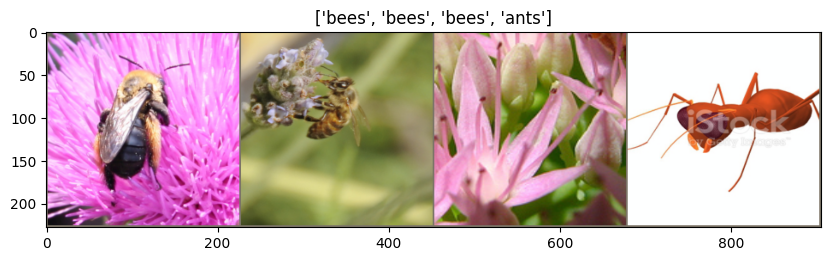

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.asarray(data_stds) * inp + np.asarray(data_means)
    inp = np.clip(inp, 0, 1)       # Clip to intensity outliers to [0, 1] range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


# Get a batch of training data
first_inputs, first_classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(first_inputs)

plt.figure(figsize=(10, 15))
imshow(out, title=[class_names[x] for x in first_classes])
plt.show()

## Training the model

Now, let's write a general function to train a model. The function will:

- Run for a given number of epochs
- For each epoch, there will be a training phase (where the model will be updated from the previous epoch) and a validation phase (where it will be applied to the validation set for prediction)
- Save the best model (based on the performance on the validation set)

Importantly, we will also **schedule the learning rate** (LR) (i.e. change it during training). In the function, the parameter ``scheduler`` is an LR scheduler object from [``torch.optim.lr_scheduler``](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print('----------------')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # move data to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # update learning rate with scheduler
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}")

            # deep copy the model with best accuracy on validation set
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val acc: {best_acc:4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

Let's also define a generic function to use the model to predict the classes of a few images (from the validation set) and to visualize the results:

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f"Predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])        # move back the data to the CPU for visualisation

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the CNN

Finetuning a CNN consists in taking a model (i.e. **architecture and weights**) pre-trained on a given dataset (very often ImageNet) and using it as a starting point for training on a different dataset. The steps involved in finetuning are the following:

1. Load a pre-trained model
2. Reset the final layer (technically needed only if the number of classes is different between the two datasets, but generally always a good idea)
3. Perform training on the new dataset

In this example, we will first download the *ResNet18* model from the model zoo of `torchvision` (more information on how this works can be found [here](https://pytorch.org/vision/stable/models.html)). Then, we will reset the last fully-connected layer and perform training on our own dataset.

Download the pre-trained model:

In [14]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')

Create a new fully-connected layer and use it to replace the original one of *Resnet18*. It will need to have the same input dimensions as the original one, but have an output size equal to the number of classes in our dataset:

In [15]:
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

Then we can move the model to the GPU and set the remaining training parameters and criterion (i.e. the loss function):

In [16]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate

Now we can actually train our model. It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------------
train loss: 0.7198 acc: 0.6598
val loss: 0.1505 acc: 0.9477

Epoch 1/24
----------------
train loss: 0.3692 acc: 0.8279
val loss: 0.2665 acc: 0.8889

Epoch 2/24
----------------
train loss: 0.6655 acc: 0.7213
val loss: 0.4689 acc: 0.8170

Epoch 3/24
----------------
train loss: 0.6496 acc: 0.7541
val loss: 0.6029 acc: 0.8105

Epoch 4/24
----------------
train loss: 0.4220 acc: 0.8443
val loss: 0.2736 acc: 0.8954

Epoch 5/24
----------------
train loss: 0.5226 acc: 0.8115
val loss: 0.7018 acc: 0.8235

Epoch 6/24
----------------
train loss: 0.5565 acc: 0.8279
val loss: 0.4230 acc: 0.8497

Epoch 7/24
----------------
train loss: 0.3702 acc: 0.8279
val loss: 0.3772 acc: 0.8693

Epoch 8/24
----------------
train loss: 0.3404 acc: 0.8525
val loss: 0.3677 acc: 0.8431

Epoch 9/24
----------------
train loss: 0.2972 acc: 0.8893
val loss: 0.3019 acc: 0.8954

Epoch 10/24
----------------
train loss: 0.3510 acc: 0.8648
val loss: 0.2861 acc: 0.8824

Epoch 11/24
--------

Let's test our final result on some images:

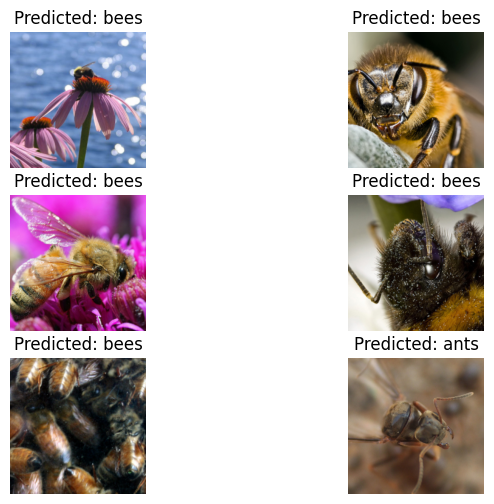

In [18]:
plt.figure(figsize=(8, 6))
visualize_model(model_ft)
plt.show()

## Saving the model

At this point, you might want to **save your trained model**. As we have seen in the previous tutorial, the recommended way to do this is to only save the model's parameters and to retain the code used to define its architecture. To save the parameters, you can use the following command:

In [19]:
torch.save(model_ft.state_dict(), 'CNN.pth')

You should now see the model file in the *Files* folder in the toolbar on the left side. 

PyTorch offers other ways to achieve model persistence and also provides an easy way to **load directly on CPU models that were trained on GPU** (allowing testing on machines without acceleration). To learn more about these topics, make sure to visit this [tutorial](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

## Task 1.1: Train a CNN as fixed feature extractor

Sometimes fine-tuning can be difficult to perform because of computational limitations. In these cases, an alternative is to use the CNN as a feature extractor, essentially keeping the first layers of the CNN frozen during training (i.e. avoiding weight updates) and simply training the final layers.

**Use the pre-trained ResNet18 as a feature extractor**. More in details:

1. Load a ResNet18 model pre-trained on ImageNet
2. Reset the final layer
3. Perform training on the new dataset **updating only the weights of the final layer**

In [20]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

##############################################################################
# TODO: use ResNet18 as feature extractor                                    #
##############################################################################
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Let's now train the model:

In [21]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------------
train loss: 0.7777 acc: 0.5902
val loss: 0.3398 acc: 0.8562

Epoch 1/24
----------------
train loss: 0.5283 acc: 0.7582
val loss: 0.3226 acc: 0.8431

Epoch 2/24
----------------
train loss: 0.5024 acc: 0.7623
val loss: 0.1931 acc: 0.9346

Epoch 3/24
----------------
train loss: 0.4571 acc: 0.7992
val loss: 0.1719 acc: 0.9542

Epoch 4/24
----------------
train loss: 0.7930 acc: 0.7295
val loss: 0.3734 acc: 0.8627

Epoch 5/24
----------------
train loss: 0.4159 acc: 0.8525
val loss: 0.4092 acc: 0.8431

Epoch 6/24
----------------
train loss: 0.4282 acc: 0.8361
val loss: 0.1557 acc: 0.9542

Epoch 7/24
----------------
train loss: 0.3271 acc: 0.8648
val loss: 0.1608 acc: 0.9608

Epoch 8/24
----------------
train loss: 0.2997 acc: 0.8934
val loss: 0.1868 acc: 0.9346

Epoch 9/24
----------------
train loss: 0.2899 acc: 0.8811
val loss: 0.1610 acc: 0.9542

Epoch 10/24
----------------
train loss: 0.3404 acc: 0.8607
val loss: 0.1506 acc: 0.9412

Epoch 11/24
--------

Did you notice how much faster this was compared to fine-tuning?

Now let's test it on a few images:

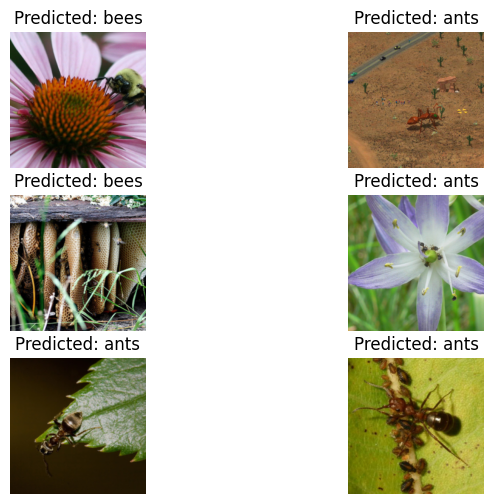

In [22]:
plt.figure(figsize=(8, 6))
visualize_model(model_conv)
plt.show()

# 2: (Optional) Object Detection Finetuning

If you managed to finish this tutorial and feel like you have fully understood its content, feel free to move to something more challenging like the [Object Detection Finetuning Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) from PyTorch: in the linked page you will also find an easy-to-access Colab notebook to guide you through the tutorial itself.

# 3: Using a pre-trained, CNN-based face detector

In a previous tutorial, we learned how to use a pre-trained model of the **famous Viola-Jones object detector** to identify (and then blur) faces in an image. In that tutorial we also learned that relatively simple image transformations (like rescaling) were able to wreak havoc on it, substantially lowering the amount of correctly predicted faces in the image. Another aspect is that most pre-trained Viola-Jones models are usually reasonably good at detecting full, frontal poses, but struggle quite a lot with poses more similar to a profile or partially occluded. 

Let's see if this is the case by testing the pre-trained model on an image showing people with rather complex face poses. To do this, we will copy-paste the code we used in the previous lab tutorial:

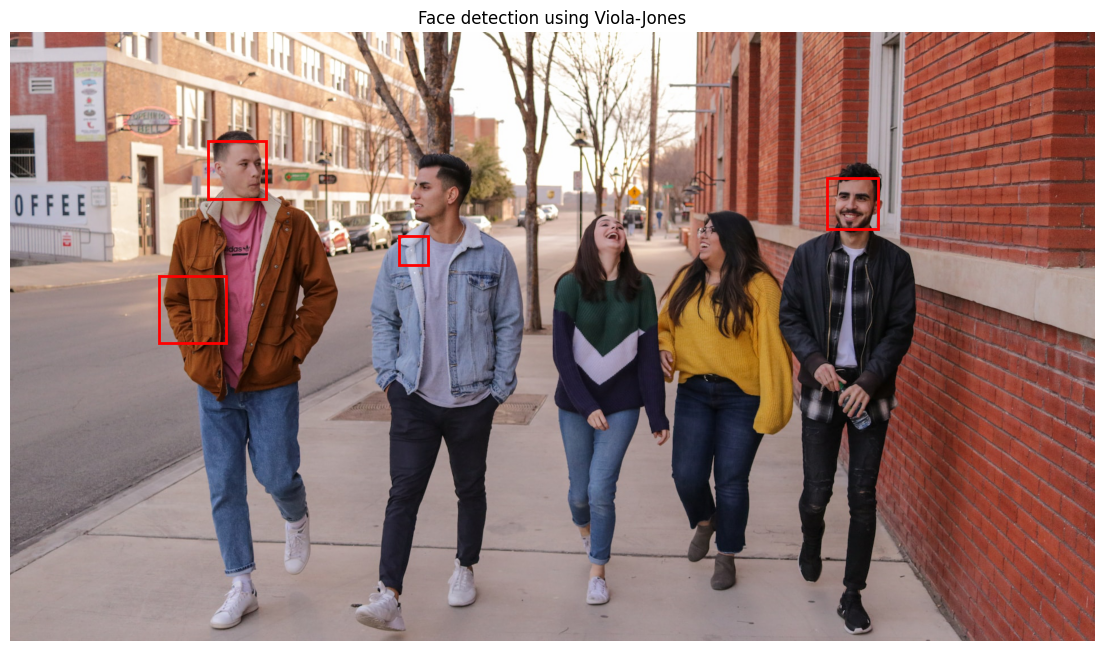

In [23]:
from skimage import io, color, img_as_ubyte
import cv2
import matplotlib.pyplot as plt
from matplotlib import patches

img = io.imread(os.path.join(GOOGLE_DRIVE_PATH, 'eliott-reyna.jpg')) 
# Photo by Eliott Reyna licensed under the Unsplash License

img_gray = color.rgb2gray(img)
img_gray = img_as_ubyte(img_gray)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces_VJ = face_cascade.detectMultiScale(img_gray)

fig, ax = plt.subplots(figsize=(14, 8))
ax.imshow(img), ax.set_axis_off(), ax.set_title('Face detection using Viola-Jones')

for face in faces_VJ:
    ax.add_patch(
        patches.Rectangle(xy=(face[0], face[1]), width=face[2], height=face[3],
                          fill=False, color='r', linewidth=2))
plt.show()

Clearly not ideal! We might be able to improve the result by tweaking the hyper-parameters in `detectMultiScale` or by training a new model from scratch, but there's only so much Viola-Jones can do.

Fortunately, some of the latest CNN-based face detector are instead much more able to deal with these issues. One of the most commonly used ones is **MTCNN**, which uses a multi-task cascade of different CNNs. You can read more about it in [this blog post](https://medium.com/@iselagradilla94/multi-task-cascaded-convolutional-networks-mtcnn-for-face-detection-and-facial-landmark-alignment-7c21e8007923) or in the [original paper](https://arxiv.org/pdf/1604.02878.pdf). Pre-trained models of MTCNN for PyTorch are available in the `facenet_pytorch` [package](https://pypi.org/project/facenet-pytorch/), with additional info on its usage available [here](https://www.kaggle.com/code/timesler/guide-to-mtcnn-in-facenet-pytorch/notebook). 

To use it, we first have to install the package:

In [24]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.2 MB/s eta 0:00:00


Then load the pre-trained model:

In [25]:
from facenet_pytorch import MTCNN
# help(MTCNN)

If you want, at this point, you can execute the command `help(MTCNN)` for info on how to use the model itself.

Finally, we can test it on the previous image with the following, very simple code:



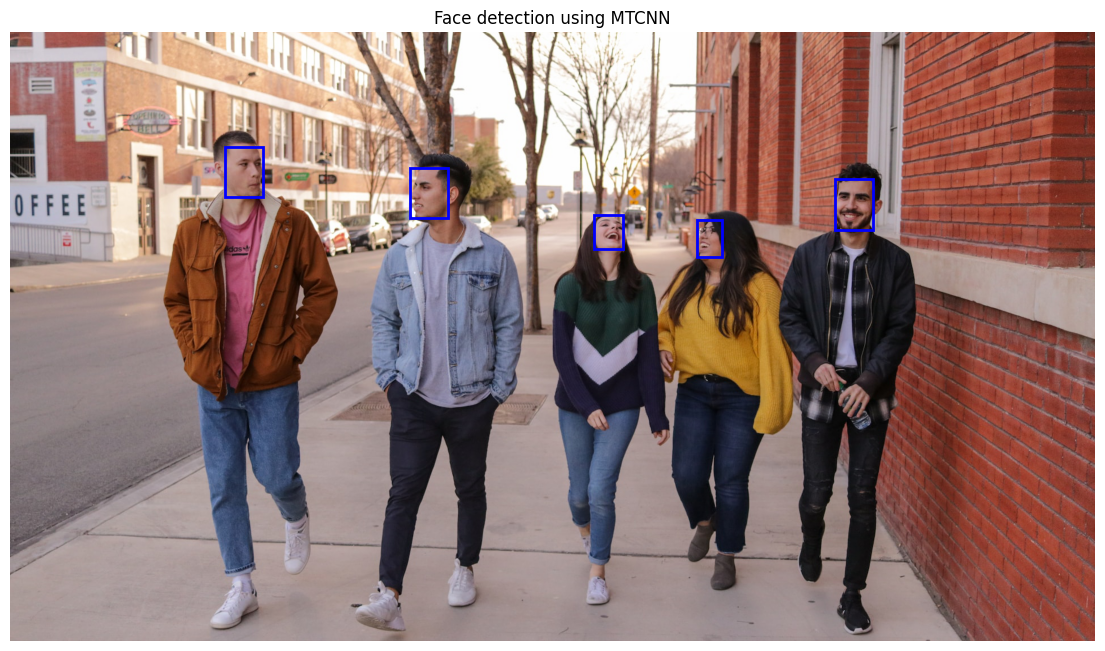

In [26]:
mtcnn = MTCNN(keep_all=True)      # If you want a faster prediction, you can use Colab's GPUs by adding 'device' as an argument    
faces_MTCNN, _ = mtcnn.detect(img, landmarks=False)       # MTCNN can also detect facial landmarks (e.g. eyes, nose), but we are not interested

fig, ax = plt.subplots(figsize=(14, 8))
ax.imshow(img), ax.set_axis_off(), ax.set_title('Face detection using MTCNN')

if faces_MTCNN is not None:       # Slightly different syntax compared to Viola-Jones
  for face in faces_MTCNN:
    ax.add_patch(patches.Rectangle(xy=(face[0], face[1]), width=face[2]-face[0], height=face[3]-face[1],
                            fill=False, color='b', linewidth=2, label='test'))
    
plt.show()

Quite the improvement! Keep this in mind, in case you need reliable face detection.